<div class="alert alert-info text-left">
<center> <h1> Trabajo práctico final:Aprendizaje Profundo </h1></center>
<h3>Universidad Tecnológica Nacional</h3>
<h3>Facundo N. Iglesias </h3>
<h3>2023</h3>
<h3>Fuente:</h3>   
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html">Dataset Fetch people</a>
</div>


### Librerias

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import MSE
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import KFold
from sklearn.datasets import fetch_lfw_people

---

<div class="alert alert-info text-left">
<center> <h1> PREPROCESAMIENTO DE DATOS  </h1></center>
Carga, normalización, adaptación y visualización de datos.
</div>

#### Carga y visualización del dataset

In [58]:
# Utilizaremos solo imagenes de 7 personas con mas de 70 imagenes disponibles.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.5)

# Inspeccion de los tamaños
n_samples, h, w = lfw_people.images.shape

# Datos sin divir en subconjuntos
X = lfw_people.images

# Etiquetas y clases
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("h, w: (%d, %d)" % (h, w))
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)

Total dataset size:
h, w: (62, 47)
n_samples: 1288
n_classes: 7


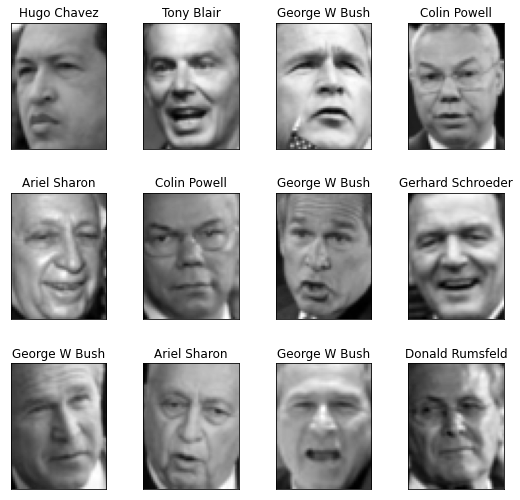

In [59]:
titles = [title(y[i], target_names) for i in range(20)]
plot_gallery(X, 12 , titles, h, w)

#### División en subconjuntos de Test y Train

In [60]:
#80/20
x_train = X[:int(n_samples*0.8)]
x_test  = X[int(n_samples*0.8):]
y_train = y[:int(n_samples*0.8)]
y_test  = y[int(n_samples*0.8):]

#### Normalización de los datos de entrada 
Para trabajar en rango acotado [0,1]

In [61]:
#Features: numeros reales, entre 0 y 255
print(X[0])
dataset = X
features = dataset.shape[1]-1

[[253.66667  254.33333  253.66667  ...  56.333332  46.666668  39.      ]
 [254.       254.       253.       ...  58.        48.333332  40.666668]
 [250.       247.       243.33333  ...  56.666668  48.333332  42.333332]
 ...
 [ 73.333336  58.        39.666668 ...  94.333336  91.333336  86.666664]
 [ 65.666664  51.666668  37.333332 ...  90.666664  90.333336  85.333336]
 [ 60.        50.        37.666668 ...  87.        88.        86.666664]]


In [62]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

#### Categorización de los datos para las neuronas de salida

In [63]:
#Transforma las dimensiones del vector de etiquetas
y_train = to_categorical(y_train, n_classes)
y_test  = to_categorical(y_test, n_classes)

In [64]:
y_train.shape

(1030, 7)

In [65]:
#Entonces a la salida se activará la neurona correspondiente 
y_train[0]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

#### Transformación dimensional
Como la entrada es bidimensional (imagen alto por ancho) se debe aplatar para entrar de forma unidimensional

In [66]:
#Conservo la cantidad de filas y la cantidad de columnas es igual al producto de las dimensiones restantes
x_train.shape = (x_train.shape[0], np.prod(x_train.shape[1:]))
x_test.shape = (x_test.shape[0], np.prod(x_test.shape[1:]))

In [67]:
#La cantidad de filas se mantiene (1030) y la otra dimension es alto*ancho de cada imagen: 62*47=2914 
x_train.shape

(1030, 2914)

---

<div class="alert alert-info text-left">
<center> <h1> MODELO DE REDES DENSAS </h1></center>
Capas conexas: Los elementos de la capa anterior estan conectados con las neuronas de la capa siguiente
</div>


#### Parámetros de entrenamiento

* learning rate (Tasa de aprendizaje):No hay un numero establecido pero si es muy bajo aprende muy poco y si es muy alto el problema puede diverger sin lograr aprendizaje.

* epochs: Numero de veces que el modelo ve el conjunto total de entrenamiento.

* batch_size: La red neuronal calcula el MSE asociado asociado a los primeros batch_size elementos y luego lo va a retropropagar a la red.Esto se repite hasta completar una epoca

* seed (semilla): Aleatorizador para los pesos de la red para asi obtener en cada corrida del modelo el mismo resultado 

In [68]:
lr = 1.0
epochs = 30
batch_size = 32
np.random.seed(10)

### Arquitectura de la red

* CAPA DE ENTRADA: Tiene la dimension de la cantidad total de pixeles de la imagen: 62*47=2914 
* CAPAS OCULTAS: Realizan el procesamiento tomando los datos de la capa anterior.
    - Numero de neuronas: Arbitrario, mientras mas neuronas tenga mas tiempo tardará pero resuelve problemas mas complejos.
    - Funcion de activacion: No lineal y diferenciable. Relu: Funcion rectificada
* CAPA DE SALIDA:
    - Tiene tantas neuronas como clases tenga el problema
    - Funcion de activacion: softmax: Devuelve un valor entre 0 y 1 que representa la probabilidad de que pertenezca a la clase

* CAPAS DE DROPOUT: Mejora y simplifica al modelo. Desconecta un numero de conexiones entre capas de manera aleatorea (0.25 -> el 25% de las conexiones).

In [69]:
input_layer = Input(shape=x_train.shape[1:])
dense_1 = Dense(500, activation='relu')(input_layer)
#dropout_1 = Dropout(0.25) (dense_1)
dense_2 = Dense(500, activation='relu')(dense_1) #(dropout_1)
#dropout_2 = Dropout(0.25) (dense_2)
dense_3 = Dense(500, activation='relu')(dense_2) #(dropout_2)
#dropout_3 = Dropout(0.25) (dense_3)
output_layer = Dense(n_classes, activation='softmax')(dense_3) #(dropout_3)
#Creación del modelo
model = Model(input_layer, output_layer)

### Parámetros de entrenamiento
* Optimizacion: Resuelve el problema en el cual los pesos tienden a un valor optimo.
* rho: Asociado al momento estocastico.
* Funcion de costo: Funcion de error asociada a la salida de la red neuronal para realizar la retropropagación
* Metricas: Indicadores para el monitoreo durante el proceso de entrenamiento.
* Acc (precision): ejemplos clasificados correctamente /ejemplos totales
* mse (Error cuadratico medio): Promedio de los errores al cuadrado

In [70]:
Adadelta_optimizer = Adadelta(learning_rate=lr, rho=0.95)
model.compile(optimizer=Adadelta_optimizer, loss="categorical_crossentropy", metrics=['acc','mse'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2914)]            0         
                                                                 
 dense_6 (Dense)             (None, 500)               1457500   
                                                                 
 dense_7 (Dense)             (None, 500)               250500    
                                                                 
 dense_8 (Dense)             (None, 500)               250500    
                                                                 
 dense_9 (Dense)             (None, 7)                 3507      
                                                                 
Total params: 1962007 (7.48 MB)
Trainable params: 1962007 (7.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Entrenamiento del modelo
Las redes densas se entrenan con el método fit:
* shuffle: Mezcla los elementos en cada batch
* verbose: Imprime en pantalla el avance del proceso de entrenamiento

In [71]:
start_time = time.time()
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test,y_test), shuffle=True, verbose=1 )
end_time = time.time()
print('Demora total: {:.5f} segundos'.format(end_time-start_time))

Epoch 1/30
33/33 [==============================] - 2s 54ms/step - loss: 1.9127 - acc: 0.3233 - mse: 0.1165 - val_loss: 1.6939 - val_acc: 0.4109 - val_mse: 0.1084
Epoch 2/30
33/33 [==============================] - 2s 47ms/step - loss: 1.7339 - acc: 0.4078 - mse: 0.1113 - val_loss: 2.4719 - val_acc: 0.4109 - val_mse: 0.1489
Epoch 3/30
33/33 [==============================] - 1s 45ms/step - loss: 1.7166 - acc: 0.3942 - mse: 0.1103 - val_loss: 1.7290 - val_acc: 0.4109 - val_mse: 0.1120
Epoch 4/30
33/33 [==============================] - 1s 44ms/step - loss: 1.6694 - acc: 0.4107 - mse: 0.1081 - val_loss: 1.7814 - val_acc: 0.4031 - val_mse: 0.1154
Epoch 5/30
33/33 [==============================] - 1s 44ms/step - loss: 1.6764 - acc: 0.4136 - mse: 0.1093 - val_loss: 1.7928 - val_acc: 0.2636 - val_mse: 0.1158
Epoch 6/30
33/33 [==============================] - 1s 44ms/step - loss: 1.6526 - acc: 0.4019 - mse: 0.1080 - val_loss: 1.5511 - val_acc: 0.4845 - val_mse: 0.1016
Epoch 7/30
33/33 [====

### Evaluación del modelo

In [45]:
#Metricas
history.history.keys()

dict_keys(['loss', 'acc', 'mse', 'val_loss', 'val_acc', 'val_mse'])

Gráfico de precisión:

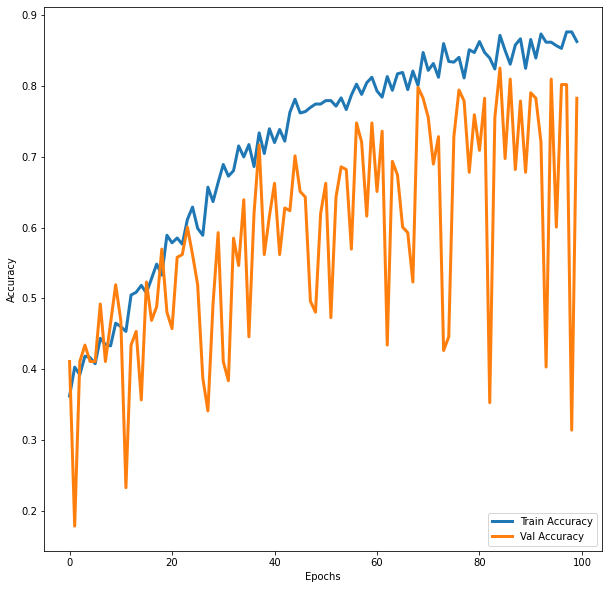

In [46]:
plotAccuracy(history)

Gráfico de MSE:

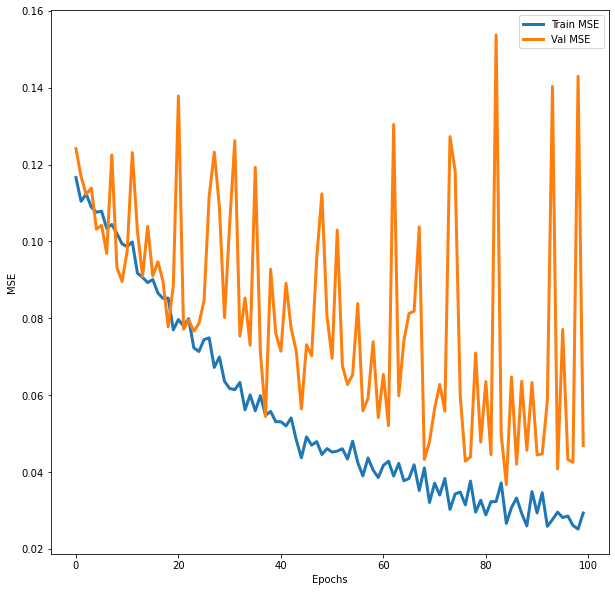

In [47]:
plotMSE(history)

Gráfico de funcion de costo:

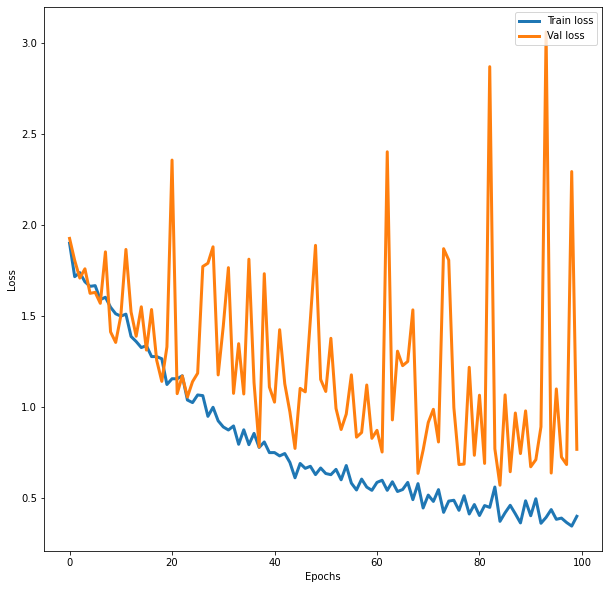

In [48]:
#Mide el error con respecto a la salida de la red para cada ejemplo 
plotLoss(history)

### Overfiting:
Diferencia entre las curvas debido al sobreajuste del conjunto de entrenamiento. Cuando se alcanza este punto por más que aumente las epocas no voy a conseguir mejores resultados en el modelo. El dropout disminuye este gap pero tambien la precision.

### Predicciones
Predicción individual:

In [49]:
x_single_test = x_test[1] #Primera imagen del dataset 
y_single_test = y_test[1] #Primera etiqueta del dataset 
#Modifico las dimensiones para que sean las de un vector aplastado
x_single_test.shape = (1,x_single_test.shape[0]) 
y_single_test.shape = (1,y_single_test.shape[0])

In [50]:
#Prediccion:
model.predict(x_single_test, verbose=1)

1/1 [==============================] - 0s 86ms/step


array([[4.30930918e-08, 1.67092797e-03, 1.06255677e-04, 9.97512698e-01,
        8.31826219e-06, 1.14538096e-07, 7.01646029e-04]], dtype=float32)

In [51]:
target_names[3]

'George W Bush'

Evaluación de la precision de la red respecto a esta predicción:

In [52]:
model.evaluate(x_single_test, y_single_test,verbose=1) #Resultado 100% en este caso

1/1 [==============================] - 0s 25ms/step - loss: 0.0025 - acc: 1.0000 - mse: 1.3546e-06


[0.0024903970770537853, 1.0, 1.3546195987146348e-06]

In [53]:
y[int(n_samples*0.8)+1]

3

---

<div class="alert alert-info text-left">
<center> <h1> IMPLEMENTACIÓN CON K-FOLDS </h1></center>
Técnica de validación cruzada: Consiste en realizar iteraciones (FOLDS) y por cada una de ellas dividir de forma diferente el dataset en subconjuntos de train y test. 
</div>

### Parámetros

In [ ]:
lr = 1.0
epochs = 30
batch_size = 32
k = 5 #FOLDS: Division del subconjunto 20% test 80% train

### Folding & Entrenamiento

In [54]:
start_time = time.time()
acc = np.zeros((k, epochs))
kfolds = KFold(n_splits=k, shuffle=True, random_state=None)
for i, (train_index, test_index) in enumerate(kfolds.split(X)):
    #Dividir el dataset
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index,], y[test_index]
    #Normalizacion entrada
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    #Categorizacion salida
    y_train = to_categorical(y_train, n_classes)
    y_test  = to_categorical(y_test, n_classes)
    #Transformacion unidimensional
    x_train.shape = (x_train.shape[0], np.prod(x_train.shape[1:]))
    x_test.shape = (x_test.shape[0], np.prod(x_test.shape[1:]))
    history_fold = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True, verbose=1)
    acc[i,:] = np.array(history_fold.history['val_acc'])
end_time = time.time()
print('\nElapsed Dense Model training time: {:.5f} seconds'.format(end_time-start_time))

Epoch 1/30
33/33 [==============================] - 1s 44ms/step - loss: 0.3955 - acc: 0.8689 - mse: 0.0273 - val_loss: 0.3780 - val_acc: 0.8721 - val_mse: 0.0266
Epoch 2/30
33/33 [==============================] - 1s 43ms/step - loss: 0.4531 - acc: 0.8505 - mse: 0.0312 - val_loss: 0.6364 - val_acc: 0.7984 - val_mse: 0.0411
Epoch 3/30
33/33 [==============================] - 1s 44ms/step - loss: 0.4030 - acc: 0.8641 - mse: 0.0282 - val_loss: 1.3110 - val_acc: 0.6279 - val_mse: 0.0849
Epoch 4/30
33/33 [==============================] - 1s 44ms/step - loss: 0.5582 - acc: 0.8010 - mse: 0.0397 - val_loss: 0.3096 - val_acc: 0.9031 - val_mse: 0.0199
Epoch 5/30
33/33 [==============================] - 1s 45ms/step - loss: 0.4160 - acc: 0.8699 - mse: 0.0289 - val_loss: 1.5084 - val_acc: 0.5698 - val_mse: 0.0941
Epoch 6/30
33/33 [==============================] - 1s 45ms/step - loss: 0.4170 - acc: 0.8563 - mse: 0.0294 - val_loss: 0.4197 - val_acc: 0.8605 - val_mse: 0.0286
Epoch 7/30
33/33 [====

33/33 [==============================] - 2s 46ms/step - loss: 0.2763 - acc: 0.9117 - mse: 0.0192 - val_loss: 0.4387 - val_acc: 0.8566 - val_mse: 0.0303
Epoch 22/30
33/33 [==============================] - 2s 47ms/step - loss: 0.2435 - acc: 0.9049 - mse: 0.0186 - val_loss: 2.0805 - val_acc: 0.6473 - val_mse: 0.0829
Epoch 23/30
33/33 [==============================] - 2s 46ms/step - loss: 0.2465 - acc: 0.9194 - mse: 0.0164 - val_loss: 0.3936 - val_acc: 0.8876 - val_mse: 0.0251
Epoch 24/30
33/33 [==============================] - 2s 46ms/step - loss: 0.2905 - acc: 0.9078 - mse: 0.0204 - val_loss: 0.3845 - val_acc: 0.8760 - val_mse: 0.0253
Epoch 25/30
33/33 [==============================] - 1s 44ms/step - loss: 0.2969 - acc: 0.8961 - mse: 0.0209 - val_loss: 0.4588 - val_acc: 0.8295 - val_mse: 0.0324
Epoch 26/30
33/33 [==============================] - 1s 44ms/step - loss: 0.3587 - acc: 0.8922 - mse: 0.0239 - val_loss: 0.4330 - val_acc: 0.8333 - val_mse: 0.0315
Epoch 27/30
33/33 [=========

33/33 [==============================] - 1s 44ms/step - loss: 0.2090 - acc: 0.9234 - mse: 0.0152 - val_loss: 0.9745 - val_acc: 0.7510 - val_mse: 0.0575
Epoch 12/30
33/33 [==============================] - 1s 44ms/step - loss: 0.2391 - acc: 0.9214 - mse: 0.0167 - val_loss: 0.1229 - val_acc: 0.9533 - val_mse: 0.0091
Epoch 13/30
33/33 [==============================] - 1s 44ms/step - loss: 0.2256 - acc: 0.9253 - mse: 0.0161 - val_loss: 0.1641 - val_acc: 0.9339 - val_mse: 0.0130
Epoch 14/30
33/33 [==============================] - 1s 44ms/step - loss: 0.2904 - acc: 0.9040 - mse: 0.0204 - val_loss: 0.5112 - val_acc: 0.8405 - val_mse: 0.0344
Epoch 15/30
33/33 [==============================] - 1s 44ms/step - loss: 0.2608 - acc: 0.9234 - mse: 0.0175 - val_loss: 0.2462 - val_acc: 0.9027 - val_mse: 0.0195
Epoch 16/30
33/33 [==============================] - 1s 44ms/step - loss: 0.4313 - acc: 0.8623 - mse: 0.0281 - val_loss: 0.2372 - val_acc: 0.9144 - val_mse: 0.0175
Epoch 17/30
33/33 [=========

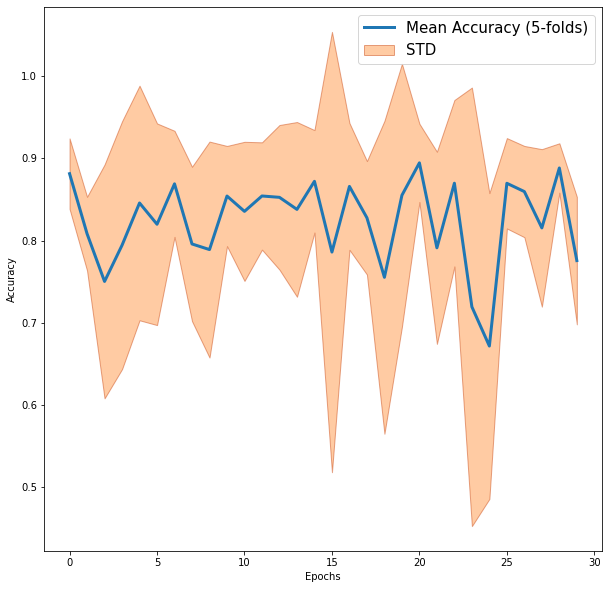

In [55]:
plotKFolds(acc=acc,epochs=epochs)

#### Predicción individual

In [56]:
#Prediccion:
model.predict(x_single_test, verbose=1)

1/1 [==============================] - 0s 19ms/step


array([[8.7561687e-11, 1.9986957e-04, 1.5770805e-06, 9.9977356e-01,
        5.2495375e-07, 6.7130790e-10, 2.4531948e-05]], dtype=float32)

In [57]:
model.evaluate(x_single_test, y_single_test,verbose=1) #Resultado 100% en este caso

1/1 [==============================] - 0s 23ms/step - loss: 2.2647e-04 - acc: 1.0000 - mse: 1.3118e-08


[0.000226472009671852, 1.0, 1.3118087949237633e-08]

-----

<div class="alert alert-info text-left">
<center> <h1> MODELO DE REDES CONVOLUCIONALES </h1></center>
Diseñado para trabajar en procesamiento de imagenes 2D. A cada imagen de entrada se aplica un filtro/Kernel/feautre y se obtiene otra imagen reducida.
</div>

#### Parámetros de entrenamiento

In [22]:
lr = 1.0
epochs = 30
batch_size = 32
np.random.seed(10)
Adadelta_optimizer = Adadelta(learning_rate=lr, rho=0.95)

In [23]:
#Division del dataset 80/20
x_train = X[:int(n_samples*0.8)]
x_test  = X[int(n_samples*0.8):]
y_train = y[:int(n_samples*0.8)]
y_test  = y[int(n_samples*0.8):]
#Normalizacion
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
#Transformacion
y_train = to_categorical(y_train, n_classes)
y_test  = to_categorical(y_test, n_classes)

### Arquitectura de la red

* CAPA DE ENTRADA: Tiene la dimension de la cantidad total de pixeles de la imagen: 62*47=2914 
* CAPAS OCULTAS: Realizan el procesamiento tomando los datos de la capa anterior.
    - Numero de neuronas: Arbitrario, mientras mas neuronas tenga mas tiempo tardará pero resuelve problemas mas complejos.
    - Funcion de activacion: No lineal y diferenciable. Relu: Funcion rectificada
* CAPA DE SALIDA:
    - Tiene tantas neuronas como clases tenga el problema
    - Funcion de activacion: softmax: Devuelve un valor entre 0 y 1 que representa la probabilidad de que pertenezca a la clase

* CAPAS DE DROPOUT: Mejora y simplifica al modelo. Desconecta un numero de conexiones entre capas de manera aleatorea (0.25 -> el 25% de las conexiones).

* CAPAS DE POOLING: Disminuyen el tamaño de la red (similar a capas de dropout) para lograr una disminución de la capacidad computacional del problema y por ende del sobreajuste.

* CAPA DE FLATTEN: Transforma la estructura para conectar con una red unidimensional conexa (red densa).

In [24]:
x_train = x_train[...,np.newaxis]
#Red de entrada (igual que red densa)
input_layer = Input(shape=x_train.shape[1:])
#Red convolucional
#Parametros: numero de kernels=32, tamaño del kernel, funcion de activacion
conv_1 = Conv2D(32, (3, 3), activation='relu') (input_layer)
conv_2 = Conv2D(64, (3, 3), activation='relu') (conv_1)
#Capa de pooling: Se queda con el pixel de mayor valor en una ventana de 2x2 (disminuye las dimensiones)
pool_1 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
#Capa de dropout: Disminuye sobreajuste
dropout_1 = Dropout(0.25) (pool_1)
#Capa de flatten: Aplasta las dimensiones de la red para pasar luego por una capa densa:
flatten_1 = Flatten() (dropout_1)
#Capa densa:
dense_1 = Dense(100, activation='relu') (flatten_1)
dropout_2 = Dropout(0.25) (dense_1)
output_layer = Dense(n_classes, activation='softmax') (dropout_2)
model_conv = Model(input_layer, output_layer)

In [25]:
model_conv.compile(optimizer=Adadelta_optimizer, loss='categorical_crossentropy', metrics=['acc', 'mse'])
model_conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 62, 47, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 45, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 43, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 21, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 29, 21, 64)        0         
                                                                 
 flatten (Flatten)           (None, 38976)             0         
                                                             

#### Entrenamiento

In [26]:
start_time = time.time()
history_conv = model_conv.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True, verbose=1)
end_time = time.time()
print('\nElapsed Dense Model training time: {:.5f} seconds'.format(end_time-start_time))

Epoch 1/30
33/33 [==============================] - 10s 255ms/step - loss: 1.8582 - acc: 0.3505 - mse: 0.1161 - val_loss: 1.7147 - val_acc: 0.4109 - val_mse: 0.1108
Epoch 2/30
33/33 [==============================] - 8s 251ms/step - loss: 1.7011 - acc: 0.4194 - mse: 0.1097 - val_loss: 1.7262 - val_acc: 0.4109 - val_mse: 0.1118
Epoch 3/30
33/33 [==============================] - 9s 260ms/step - loss: 1.5957 - acc: 0.4534 - mse: 0.1035 - val_loss: 1.5126 - val_acc: 0.4109 - val_mse: 0.0983
Epoch 4/30
33/33 [==============================] - 9s 261ms/step - loss: 1.4507 - acc: 0.4699 - mse: 0.0949 - val_loss: 1.2823 - val_acc: 0.5698 - val_mse: 0.0791
Epoch 5/30
33/33 [==============================] - 9s 266ms/step - loss: 1.3671 - acc: 0.5155 - mse: 0.0905 - val_loss: 1.1681 - val_acc: 0.5349 - val_mse: 0.0782
Epoch 6/30
33/33 [==============================] - 9s 266ms/step - loss: 1.0561 - acc: 0.6058 - mse: 0.0711 - val_loss: 1.2257 - val_acc: 0.5039 - val_mse: 0.0845
Epoch 7/30
33/3

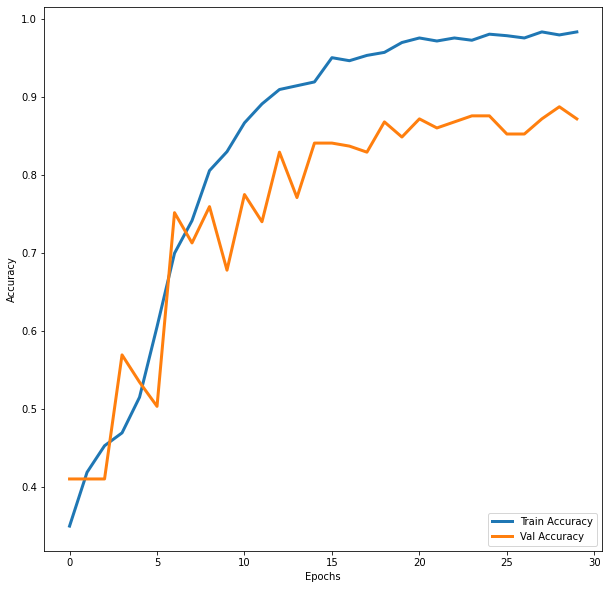

In [27]:
plotAccuracy(history_conv)

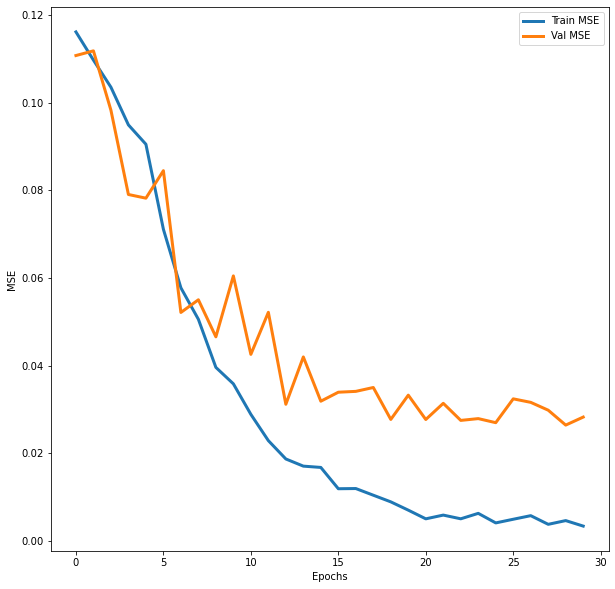

In [28]:
plotMSE(history_conv)

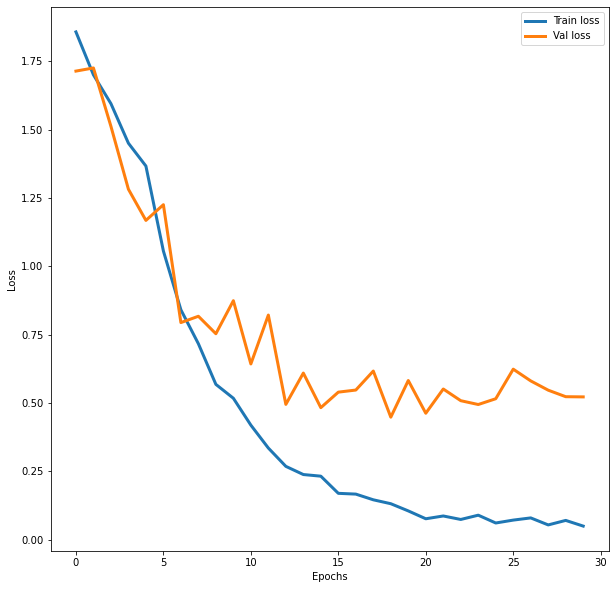

In [29]:
plotLoss(history_conv)

----

<div class="alert alert-info text-left">
<center> <h1> CONCLUSIONES </h1></center>
</div>

#### Comparativa

| METRICA / MODELO  | REDES DENSAS | K-FOLDS  | REDES CONV. |
|-------------------|--------------|----------|-------------|
| ACC               |  62,14 %     | 96,66 %  | 98,35 %     |
| MSE               |  7     %     | 0,7   %  | 0,34  %     |
| LOSS              |  99,34 %     | 10    %  | 5  %        |
| EPOCHS            |  30          | 30x5f    | 30          |
| DELAY             |  45    s     | 230 s    | 274   s     |

#### Redes densas
* La precisión obtenida es la más baja y el error medio cuadrático el más alto. Para mejorar estas metricas se debe incrementar el número de epocas consumiendo una mayor capacidad computacional.
* Las curvas presentan mayor ruido, es decir picos positivos y negativos.

#### Folding
* Con la misma cantidad de epocas y aplicando 5 iteraciones, la precisión y el error cuadrático medio mejoran notablemente a costo de demorar 5 veces más en el procesamiento. Investigar: Montecarlo
* A su vez, el hecho de realizar un proceso iterativo el error se promedia.

#### Redes convolucionales
* Con este modelo se obtiene la mayor precisión, el menor error cuadrático medio y la menor perdida. También es el modelo que tiene mayor demora de procesamiento.


------

<div class="alert alert-info text-left">
<center> <h1> FUNCIONES AUXILIARES PARA GRÁFICAR </h1></center>
</div>

In [30]:
def plot_gallery(images, number, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(number):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y, target_names):
    return "%s" % (target_names[y])

def plotAccuracy(history):
    f = plt.figure(figsize=(10,10))
    plt.plot(history.history['acc'], linewidth=3, label='Train Accuracy')
    plt.plot(history.history['val_acc'], linewidth=3, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
 #   plt.axis([0, 30, 0.75, 1])
    plt.legend(loc='lower right')
    plt.show()
    
def plotMSE(history):
    f = plt.figure(figsize=(10,10))
    plt.plot(history.history['mse'], linewidth=3, label='Train MSE')
    plt.plot(history.history['val_mse'], linewidth=3, label='Val MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
  #  plt.axis([0, 30, 0, 0.02])
    plt.legend(loc='upper right')
    plt.show()

def plotLoss(history):
    f = plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'], linewidth=3, label='Train loss')
    plt.plot(history.history['val_loss'], linewidth=3, label='Val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.axis([0, 30, 0, 0.5])
    plt.legend(loc='upper right')

def plotKFolds(acc,epochs):
    acc_mean = np.mean(acc, axis=0)
    acc_std = np.std(acc, axis=0)
    f = plt.figure(figsize=(10,10))
    plt.plot(range(epochs),acc_mean, linewidth=3, label='Mean Accuracy (5-folds)')
    plt.fill_between(range(epochs), acc_mean - acc_std,  acc_mean + acc_std, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', label='STD')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='best', fontsize=15)
    plt.show()

---